# Verify the Conv-VAE sensorprocessing

Load a pre-trained model specified by an experiment/run trained by Train-Conv-VAE

This notebook runs a number of visualizations that allow to illustrate the performance of the trained encoding. The verification here primarily happens through visual observation. 

In [1]:
import sys
sys.path.append("..")
# adding the Julian-8897-Conv-VAE-PyTorch into the path

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

sys.path.append(Config()["conv_vae"]["code_dir"])
# from encoding_conv_vae.conv_vae import latest_json_and_model

from sensorprocessing import sp_conv_vae
from sensorprocessing import sp_helper
from sensorprocessing.sp_helper import get_transform_to_sp, load_picturefile_to_tensor

from demonstration.demonstration import Demonstration

import matplotlib.pyplot as plt
import pathlib
import random

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# At some point in the development, this hack was necessary for some reason. 
# It seems that as of Feb 2025, the code runs on Windows and Linux without it.
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

***ExpRun**: Loading pointer config file:
	C:\Users\lotzi\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	c:\Users\lotzi\Work\_Config\BerryPicker\cfg\settings.yaml
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\pathlib\__init__.py
Using device: cuda


### Exp-run initialization
Create the exp/run-s that describe the parameters of the training. 
Some of the code here is structured in such a way as to make the notebook automatizable with papermill.

In [ ]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten

experiment = "sensorprocessing_conv_vae"
# run = "sp_vae_256" 
run = "sp_vae_128" 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"
# If not None, set an external experiment path
external_path = None

#### Temporary values - these would be overwritten by the flow  #####
creation_style = "exist-ok"
data_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/result"
external_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/exprun"
experiment = "sensorprocessing_conv_vae"
# run = "_flow_sp_conv_vae_0001"
run = "_flow_sp_conv_vae_0002"

In [3]:
# create the necessary exp/run objects

if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)

# The experiment/run we are going to run: the specified model will be created
exp = Config().get_experiment(experiment, run, creation_style=creation_style)
print(exp)

***ExpRun**: Experiment config path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun
***ExpRun**: Experiment sensorprocessing_conv_vae copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\sensorprocessing_conv_vae
***ExpRun**: Experiment robot_al5d copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\robot_al5d
***ExpRun**: Experiment demonstration copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\demonstration
***ExpRun**: Experiment data path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result
***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/_flow_sp_conv_vae_0002 successfully loaded
Experiment:
    class: ConvVaeSensorProcessing
    clean_checkpoints: true
    data_dir: c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002
    epochs: 300
    exp_run_sys_indep_file: c:\Users\lotzi\Wo

## Verify the Conv-VAE by visual reconstruction
We can verify a Conv-VAE model visually based on its ability to recover the input image from the encoding. The intuition here would be that information that is lost during the recovery is not present in the encoding, and thus it won't be usable by the algorithms using this encoding either.

In [4]:
sp = sp_conv_vae.ConvVaeSensorProcessing(exp, device)
transform = get_transform_to_sp(exp)


# Visualize the VAE reconstruction

In [5]:
def visualize_VAE(sp, image, name, axoriginal, axreconstr):
    """Helper function to show the original and the reconstruction in fields of a picture."""
    # Running the input on the output
    output, mu, logvar = sp.model(image)
    # Output: the visual reconstruction
    original = image[0].cpu().permute(1, 2, 0).detach().numpy()
    output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
    # Showing the input and the reconstruction    
    #axoriginal.imshow(image.to("cpu").numpy()[0][0])
    axoriginal.imshow(original)
    axoriginal.set_title(f"{name}-orig")
    axreconstr.imshow(output_for_pic)
    axreconstr.set_title(f"{name}-recon")
    return output, mu, logvar

In [6]:

def get_sample_images(dataset, n, transform, device):
    """Returns n sample images from a dataset specified in the format of a list of run, demo_name, camera."""
    images_processable = []
    images_display = []
    names = []
    count = n

    demos = []; cameras = []
    total_count = 0
    for val in dataset:
        run, demo_name, camera = val
        exp_demo = Config().get_experiment("demonstration", run)
        demo = Demonstration(exp_demo, demo_name)
        demos.append(demo)
        cameras.append(camera)
        total_count += demo.metadata["maxsteps"]
    skip = total_count // n
    skipnow = 0
    for demo, camera in zip(demos, cameras):
        for i in range(demo.metadata["maxsteps"]):
            if (skipnow == 0) and (count > 0):
                image_processable, image_display = demo.get_image(i, device=device, camera=camera, transform=transform)
                images_processable.append(image_processable)
                images_display.append(image_display)
                names.append(f"demo_{i}")
                count -= 1
                skipnow = skip
            else:
                skipnow -= 1
    return names, images_processable, images_display

In [7]:
def generate_orig_rec(count, images, names):
    """Generate the illustration with the original and reconstructed images number count"""
    fig, axs = plt.subplots(2, len(images), figsize=(3*len(images), 5))
    i = 0
    for image, name in zip(images, names):
        output, mu, logvar = visualize_VAE(sp, image, name, axs[0,i], axs[1,i])
        i += 1
        # print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")
    plt.show()
    fig_reconstructed_pdf_path = pathlib.Path(exp.data_dir(), f"orig_reconstr_{count}.pdf")
    fig.savefig(fig_reconstructed_pdf_path, bbox_inches='tight')
    print(f"Creating file {fig_reconstructed_pdf_path}")
    fig_reconstructed_jpg_path = pathlib.Path(exp.data_dir(), f"orig_reconstr_{count}.jpg")
    fig.savefig(fig_reconstructed_jpg_path, bbox_inches='tight')
    print(f"Creating file {fig_reconstructed_pdf_path}")


***ExpRun**: Configuration for exp/run: demonstration/touch-apple successfully loaded
***ExpRun**: Configuration for exp/run: demonstration/touch-apple successfully loaded


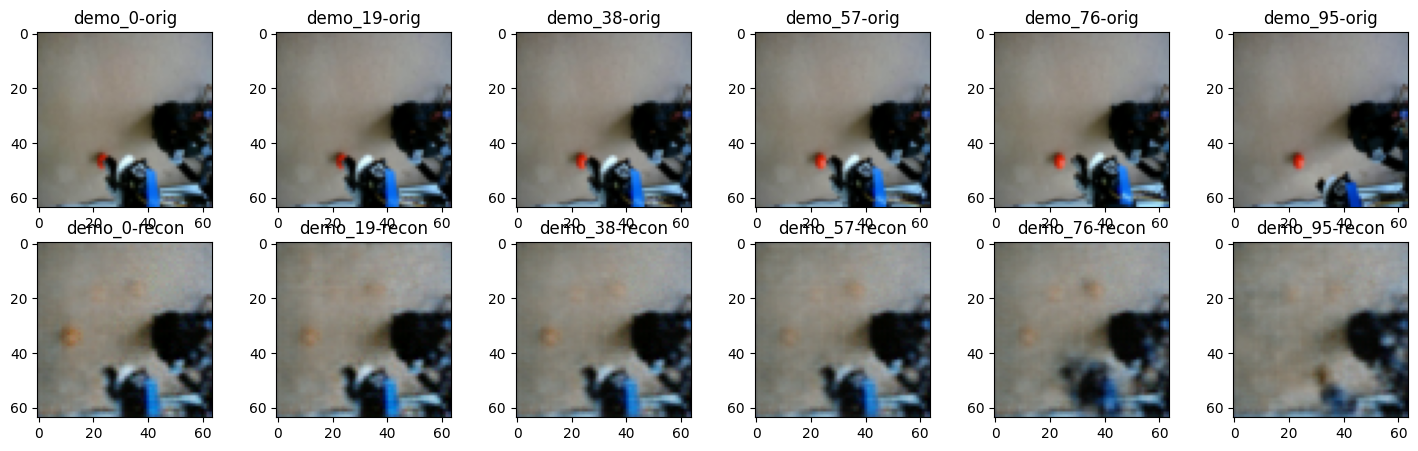

Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_0.pdf
Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_0.pdf


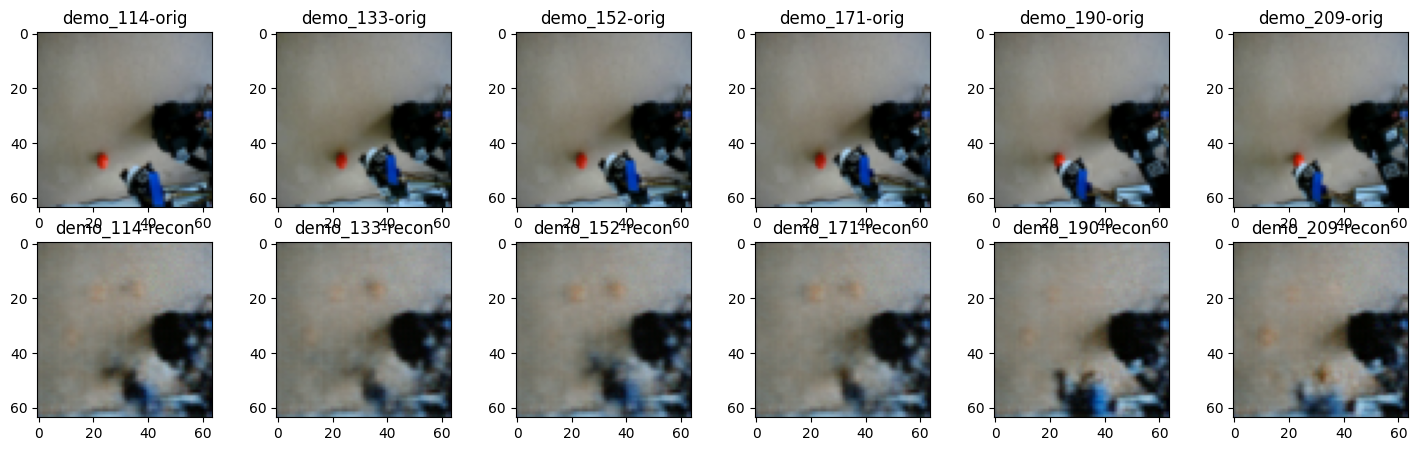

Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_1.pdf
Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_1.pdf


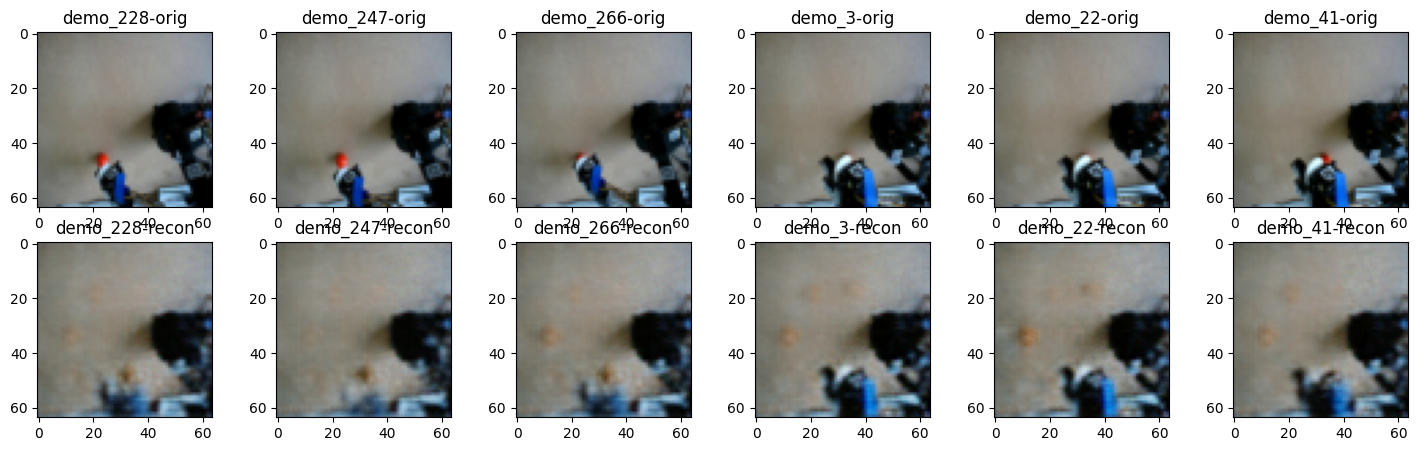

Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_2.pdf
Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_2.pdf


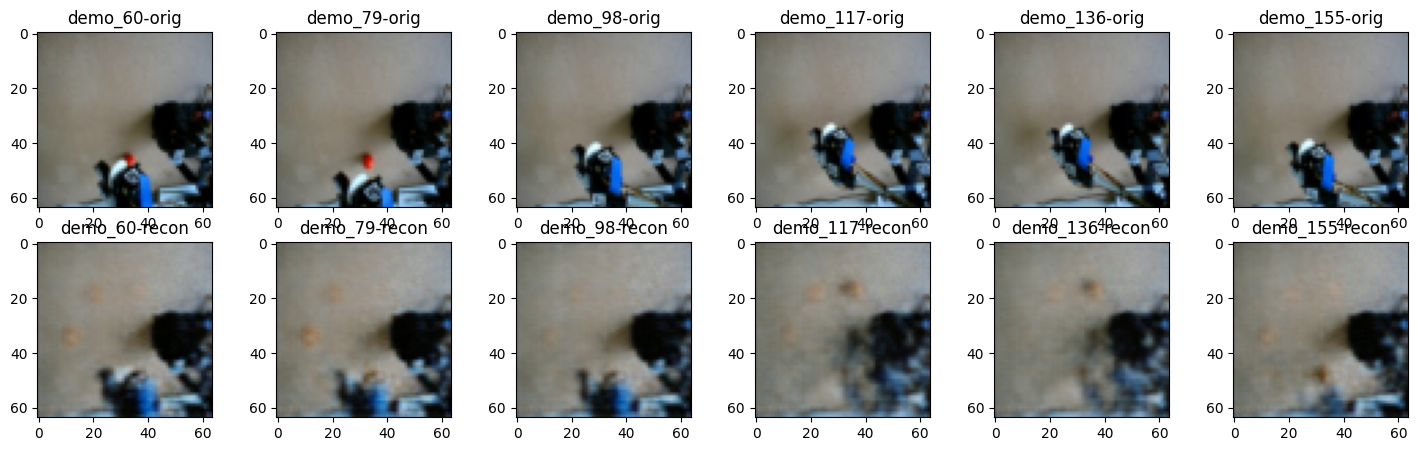

Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_3.pdf
Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_3.pdf


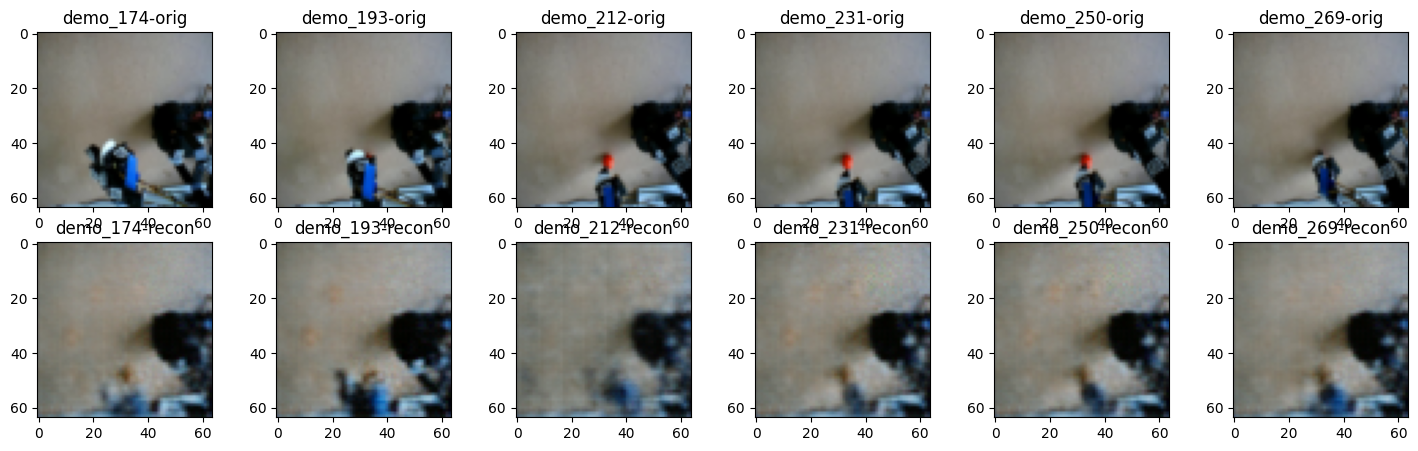

Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_4.pdf
Creating file c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result\sensorprocessing_conv_vae\_flow_sp_conv_vae_0002\orig_reconstr_4.pdf


In [8]:
n = 30
perpic = 6
names, images_processable, images_display = get_sample_images(exp["validation_data"], n, transform, device)
from_count = 0
to_count = perpic
for i in range(n//perpic):
    from_cnt = i * perpic; to_cnt = (i+1) * perpic
    generate_orig_rec(i, images_processable[from_cnt:to_cnt], names[from_cnt:to_cnt])

## Reconstruction from noisy latent encoding
FIXME: this is not immediately important, but I am leaving the code here, as it might be resurrected.

# Generating random samples from the model
Code for generating random samples from the model. 
FIXME: this is not immediately important, but I am leaving the code here, as it might be resurrected.